In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append( '..' )
from src.load_data import read_dataframe

### Downloading the data

In [3]:
df = pd.read_parquet('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet')
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037


In [4]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                          float64
Affiliated_base_number            object
dtype: object

In [5]:
print(f"Number of records for Hire Vehicle Trip: {df.shape[0]}")

Number of records for Hire Vehicle Trip: 1154112


### Computing duration

In [6]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,NaN,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,NaN,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,NaN,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,NaN,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,NaN,B00037,15.216667


In [7]:
print(f"The average of trip duration in January is: % {df.duration.mean():.2f}")

The average of trip duration in January is: % 19.17


In [8]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                          float64
Affiliated_base_number            object
duration                         float64
dtype: object

## Data preparation

<AxesSubplot:xlabel='duration', ylabel='Density'>

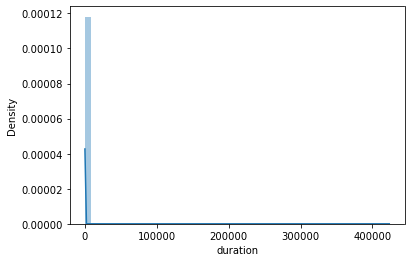

In [9]:
sns.distplot(df['duration'])

### Remove outliers
- Keep only the records where the duration was between 1 and 60 minutes (inclusive)

In [10]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.shape

(1109826, 8)

<AxesSubplot:xlabel='duration', ylabel='Density'>

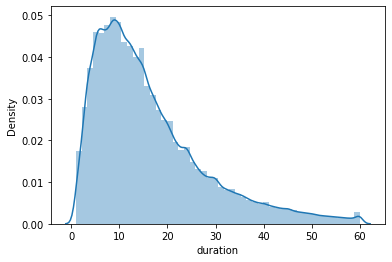

In [11]:
sns.distplot(df['duration'])

### Missing values

- Replace missing values with "-1"

In [12]:
df['PUlocationID'].fillna(value=-1, inplace=True)
df['DOlocationID'].fillna(value=-1, inplace=True)

- Get the fractions of missing values for the pickup location ID

In [13]:
print(f"Percentage of missing values is: {(df['PUlocationID'].eq(-1).mean())*100:.2f} %")

Percentage of missing values is: 83.53 %


### One-hot encoding

- Turn the dataframe into a list of dictionaries

In [14]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,NaN,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,NaN,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,NaN,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,NaN,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,NaN,B00037,9.050000


In [15]:
train_dicts = df[categorical].to_dict(orient='records')

- Fit a dictionary vectorizer

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

- Get a feature matrix from the dictionary vectorizer

In [17]:
print(f"Dimensionality of the matrix: {len(dv.feature_names_)}")

Dimensionality of the matrix: 525


### Training a model

- Train a plain linear regression model with default parameters

In [18]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

- Calculate the RMSE of the model on the training data

In [19]:
y_pred = lr.predict(X_train)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'RMSE on training data is {rmse:.2f}')


RMSE on training data is 10.53


<AxesSubplot:ylabel='Density'>

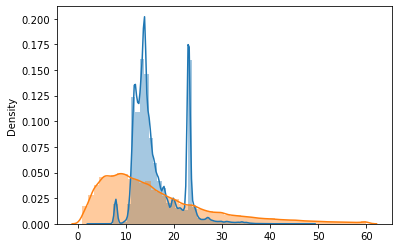

In [20]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

## Evaluating the model

In [21]:
categorical = ['PUlocationID', 'DOlocationID']
file_url = 'https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet'

df_val = read_dataframe(file_url, categorical)
len(df_val)

990113

In [22]:
df_val.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,NaN,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,NaN,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,NaN,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1.0,225.0,NaN,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1.0,61.0,NaN,B00037,8.966667


In [23]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
y_val = df_val[target].values
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'RMSE {rmse:.2f}')

RMSE 11.01
